# Modeling Stock Prices: Stochastic Calculus

One of the important ways of trading is to be able to generate stock prices dependent on what has been observed in the past.

This needs to be done for any financial asset, an important thing to consider is to look at historical data and then one time step at a time observe how our data moves.

## Geometric Browninan Motion
There are many ways to generate price samples, in this section geometric brownian motion will be used.

$dX_t = \mu(t, X_t)\,dt + \sigma(t, X_t)\,dW_t$

$X_0 = x$

Essentially the change in value (return) is going to be the constant coefficient mean product with the current price + some scaled random walk.

##### Packages

In [31]:
# import the best packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

## Example of Stock Price Path Generation: TSLA

In [32]:
# import tsla
#tsla_ts =  yf.download('TSLA','2008-01-01','2025-12-30')
#tsla_ts['Close'].to_csv('popular_stocks_data/tsla_2010-06-29_2024-12-30.csv')

Text(0, 0.5, 'Value $USD')

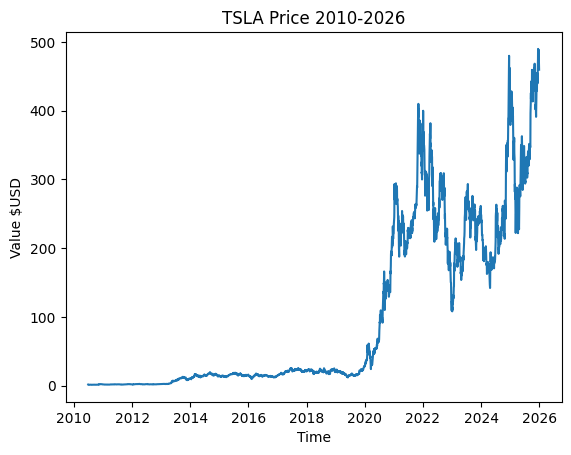

In [33]:
tsla_ts = pd.read_csv('popular_stocks_data/tsla_2010-06-29_2024-12-30.csv')
tsla_ts['Date'] = pd.to_datetime(tsla_ts['Date'])
tsla_price_returns = tsla_ts['TSLA'].pct_change()

plt.plot(tsla_ts['Date'],tsla_ts['TSLA'])
plt.title('TSLA Price 2010-2026')
plt.xlabel('Time')
plt.ylabel('Value $USD')

The above is TSLA stock data from 20210 to the beginning of 2026.

#### Log Prices
When first looking to model prices we take the log of prices. This allows for more accurate modeling:

- It turns multiplicative returns into geometric returns. For example if TSLA drops 50% then it needs a 100% gain to return back which makes statistical analysis far more difficult, so we make it so that a 50% drop needs a 50% gain to return to its original position.
- Assume movements are independent (massive assumption which is changed in the future for volatility clustering) means that we can assume CLT
- Stationarity is assumed, this allows the mu and volatlity coefficients to be utilized over longer periods of time

Text(0, 0.5, 'Value Log $USD')

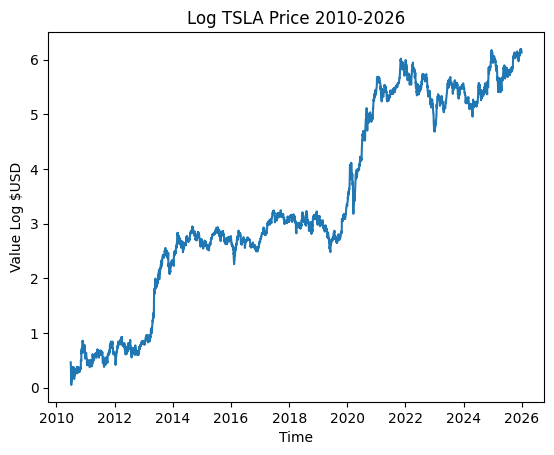

In [34]:
tsla_ts_log = np.log(tsla_ts['TSLA'])
tsla_log_returns = tsla_ts_log.diff()
plt.plot(tsla_ts['Date'], tsla_ts_log)
plt.title('Log TSLA Price 2010-2026')
plt.xlabel('Time')
plt.ylabel('Value Log $USD')

#### TSLA Returns
By looking at returns it is possible to forecast the future outcome of prices. This requires a strong understanding of modeling and probability.

Modeling is utilized so that without actually needing the market to take place over so many days it is possible to replicate what would be expected. Modeling stock prices requires many assumptions which are criticized for being unrealistic.

- Normal Distribution: We assume that stocks converge to a normal distribution for sake of modeling purposes however in reality fatter tails are far more prominent which means that we often underestimate the risk associated with prices, this is commonly referred to as Black Swan Events.
- Stationary Stock Prices: Clearly stocks move over time but for modeling time series it is assumed that series are stationary which in this case would mean that their variance and mean remain constant through time but in reality this is not true.

Log Mean is 0.0015, TSLA std is 0.0362


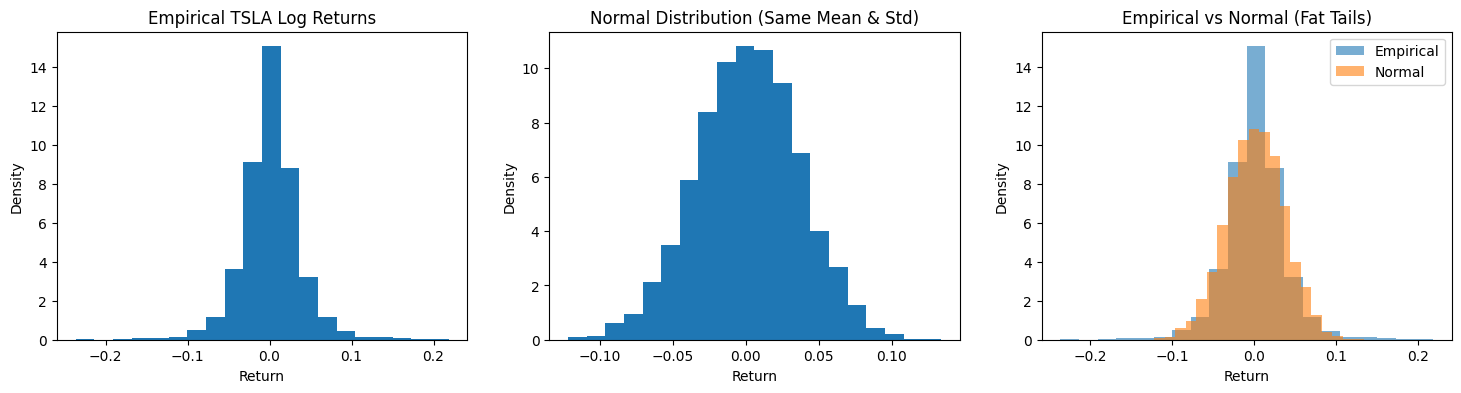

In [48]:
# compute statistics
tsla_log_returns_means = round(np.mean(tsla_log_returns), 4)
tsla_log_returns_std = round(np.std(tsla_log_returns), 4)

print(f'Log Mean is {tsla_log_returns_means}, TSLA std is {tsla_log_returns_std}')

# theoretical normal distribution
tsla_log_theoretical_dist = np.random.normal(
    tsla_log_returns_means,
    tsla_log_returns_std,
    len(tsla_log_returns)
)

# create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# empirical distribution
axes[0].hist(tsla_log_returns, bins=20, density=True)
axes[0].set_title('Empirical TSLA Log Returns')
axes[0].set_xlabel('Return')
axes[0].set_ylabel('Density')

# theoretical normal
axes[1].hist(tsla_log_theoretical_dist, bins=20, density=True)
axes[1].set_title('Normal Distribution (Same Mean & Std)')
axes[1].set_xlabel('Return')
axes[1].set_ylabel('Density')

# overlay comparison
axes[2].hist(tsla_log_returns, bins=20, density=True, alpha=0.6, label='Empirical')
axes[2].hist(tsla_log_theoretical_dist, bins=20, density=True, alpha=0.6, label='Normal')
axes[2].set_title('Empirical vs Normal (Fat Tails)')
axes[2].set_xlabel('Return')
axes[2].set_ylabel('Density')
axes[2].legend()

The theoretical normal distribution has a clear drawback as the tails do not go as far as the empirical values do. This is a common drawback as discussed earlier that normal distributions underestimate the risk however for now this assumption will be accepted for ease of modeling.

### Modeling Prices
$dX_t = \mu(t, X_t)\,dt + \sigma(t, X_t)\,dW_t$

$S_{n+1} = S_n \exp\!\left((\mu - \tfrac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t}\, Z_n\right)$


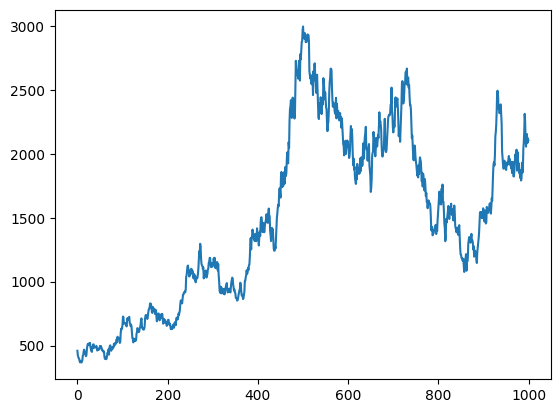

In [72]:
n_steps = 1000
dt = 1.0  # one time unit per step

mu = tsla_log_returns_means
sigma = tsla_log_returns_std

# generate iid standard normals
Z = np.random.normal(0, 1, n_steps)

future_prices = np.zeros(n_steps)
future_prices[0] = tsla_ts['TSLA'].iloc[-1]

for t in range(1, n_steps):
    future_prices[t] = future_prices[t-1] * np.exp(
        (mu - 0.5 * sigma**2) * dt
        + sigma * np.sqrt(dt) * Z[t]
    )

plt.plot(future_prices)